In [1]:
import datetime
start_time = datetime.datetime.now()

In [2]:
start_time

datetime.datetime(2019, 5, 30, 5, 57, 35, 348970)

In [3]:
import numpy as np
import pandas as pd
from tools import make_name, save_infos
import recordings_paths

from rename_labels import label_dict # dict with names for labels (Schrauben, Stift rein,...)
from rename_labels import get_opposites_out, merge_variants_screw_lr, merge_variants_screw_abc
import recordings_paths # for filling DataLoader
from plot_data import plot_slot, make_cm_all, make_cm_tt # to plot line-plots and cm_plot from JH
from plot_data import plot_precisions, plot_precisions_old
from data_prep import prep_data, select_sensor_channel

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from metamux.classification import segment_feature_union
from metamux.classification.features import util, differential
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, LeaveOneOut

In [4]:
# from all_pipes import get_pipes_feat
from all_pipes import test_pipe

In [5]:
# 'JP10, MM, CA, AR, MJ, JH, CD'
# 'JP10, MM, AR, MJ, CD'
# JP5
# JP10_MM_AR_MJ_CD_JH10

subjects = 'all10' # unten weg  ---------------------------------------------------------------TODO

sensors_lists = ['dist pos'.split(), 'acc gyro'.split(), 'dist pos acc gyro'.split()]
sensors_list = sensors_lists[2] # kann eigentlich direkt fus sein, weil unten dann eh aufgetrennt wird innerhalb dann

with_date = False

fuse_slots = None
#fuse_slots = [[210, 310], [240, 340], [250, 350]]
#fuse_slots = [[210, 310], [230, 330], [235, 335]]
#fuse_slots = [[210, 310], [220, 320], [225, 325]]

slot_filling=False # -------------------------------------------------------- wofür?

show_time=False
show_dots=False
debug=False
deep_debug=False

In [6]:
###################################################
#                                                 #
#                  PREP DATA                      #
#                                                 #
###################################################

prep_start_time = datetime.datetime.now()

loader = recordings_paths.fill_loader(debug=debug)

subjects_orig = subjects

if subjects == 'all':
    subjects = 'JP10,MM,AR,MJ,CA,CD,JH10'
elif subjects == 'all10':
    subjects = 'JP10,MM,AR,MJ,CD,JH10'
    
subjects = subjects.split(',')  # making list with subjects names
path_list = loader.get_data(subjects, debug=debug, deep_debug=deep_debug)  # get paths for subjects

In [7]:
###################################################
#                                                 #
#                   GET DATA                      #
#                                                 #
###################################################

# data und targets für subject und sensors_list holen
sessions, targets, concat_data, concat_targets, worked_with = prep_data(path_list=path_list, sensors_list=None, 
                                                                        fuse_slots=fuse_slots, slot_filling=slot_filling, 
                                                                        show_time=True, show_dots=True, 
                                                                        debug=debug, deep_debug=deep_debug)

# prepare data for each sensor
all_data_kin = [slot.iloc[:,:7].values for session in sessions for slot in session]
all_data_imu = [slot.iloc[:,7:].values for session in sessions for slot in session]
all_data_fus = [slot.values for session in sessions for slot in session]

# make groups for each segment to identify which segment belongs to which subject
groups = [path[23:25] for path in worked_with] # take initials of subjects from paths

groups_long = []
for p_index, path in enumerate(groups): # iterate over length of session and make entry for every session
    for i in range(len(sessions[p_index])):
        groups_long.append(path)

Start time = 2019-05-30 05:57:37.736583
............................................................
data prep duration = 0:00:53.383221


In [8]:
###################################################
#                                                 #
#                   PIPELINE                      #
#                                                 #
###################################################

In [9]:
import all_pipes

In [10]:
from all_pipes import pipes_feat, get_pipes

pipes = get_pipes(pipes_feat)

In [11]:
len(groups_long), len(groups_long)

(1254, 1254)

---

In [12]:
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, LeaveOneOut
cv = LeaveOneGroupOut()
cv_fus = cv.split(all_data_fus, concat_targets, groups=groups_long)

In [13]:
# make one array with all segments and targets
debug = True
all_data_fus_ar = np.array(all_data_fus)
    
concat_targets_ar = np.array(concat_targets)
if debug: type(concat_targets)

In [14]:
predicted_fus = []
backup_targets = []

In [15]:
import sklearn
from sklearn.metrics import accuracy_score

In [16]:
accs = [[[[[] for _ in range(3)] for _ in range(6)] for _ in range(6)] for _ in range(6)]

In [17]:
accs[5][5][5][2]

[]

In [18]:
ud_precs_all_pipes = [[[[] for _ in range(6)] for _ in range(6)] for _ in range(6)]

In [19]:
ud_precs_all_pipes[5][5][5]

[]

---

In [20]:
# run pipes with all subjects (LOGO)
debug = True

# lists for 3 sensors, 6 stat_pipes, 6 diff_pipes, 6 klassifikators
accs = [[[[[] for _ in range(3)] for _ in range(6)] for _ in range(6)] for _ in range(6)] # wofür? = ud_precs_all_pipes?

In [21]:
original_targets = concat_targets

In [29]:
concat_targets = original_targets

merge_opposites = False
merge_screw_lr = False
merge_screw_abc = True
        
# get labels out
if not merge_opposites:
    # concat_targets_noopp = [get_opposites_out[l] for l in concat_targets]
    concat_targets = [get_opposites_out[l] for l in concat_targets]
    if debug: print('get opposites out')
if merge_screw_lr:
    #concat_targets_abc = [merge_variants_screw_lr[l] for l in concat_targets]
    concat_targets = [merge_variants_screw_lr[l] for l in concat_targets]
    if debug: print('merge lr')
if merge_screw_abc:
    #concat_targets_lr = [merge_variants_screw_abc[l] for l in concat_targets]
    concat_targets = [merge_variants_screw_abc[l] for l in concat_targets] # TODO ---- auch für do_it_ud!!!!!!
    if debug: print('merge abc')

get opposites out
merge abc


['identity']
['min', 'max', 'mean']
60.48 75.71 89.05
66.19 81.43 94.76
60.48 82.86 93.81
78.57 85.71 97.62
69.05 75.71 91.43
52.94 84.8 90.2
------------------------------
101 64.67304625199361 81.0207336523126 92.82296650717703
101 64.67304625199361 81.0207336523126 92.82296650717703
subjects = all10
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


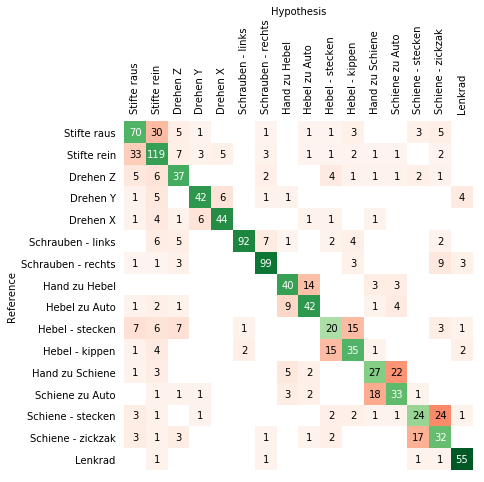

Accuracy = 64.67304625199361
Mode = plots/all10_kinect_101_lda_identity_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 932, 94

<Figure size 432x288 with 0 Axes>

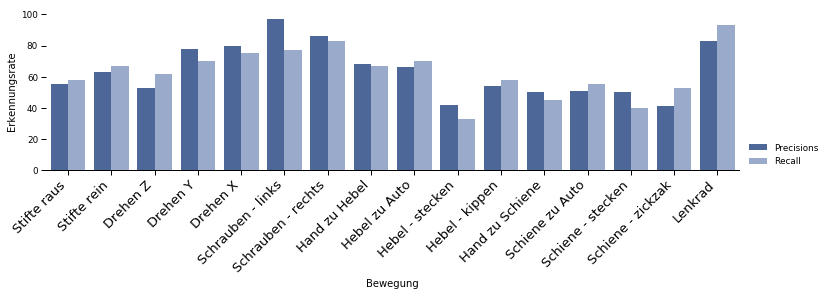

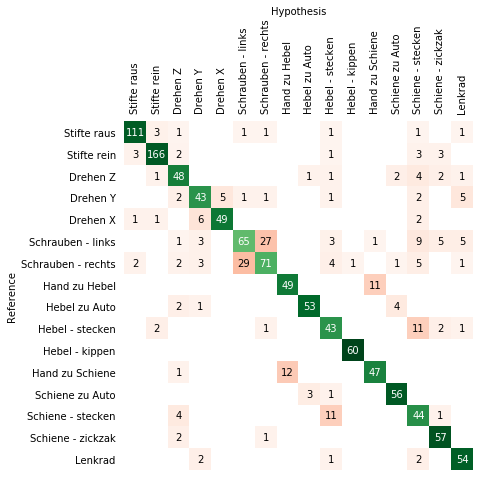

Accuracy = 81.0207336523126
Mode = plots/all10_imu_101_lda_identity_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 932, 947, 9

<Figure size 432x288 with 0 Axes>

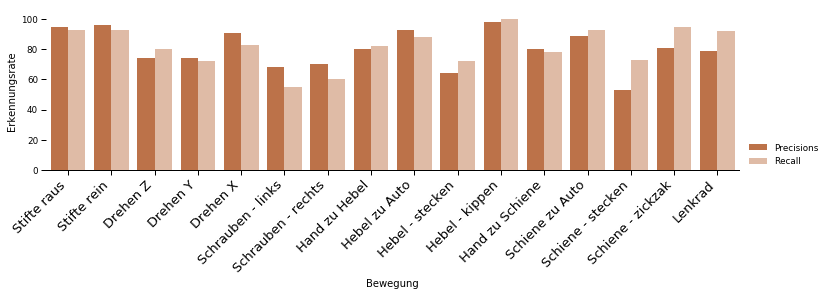

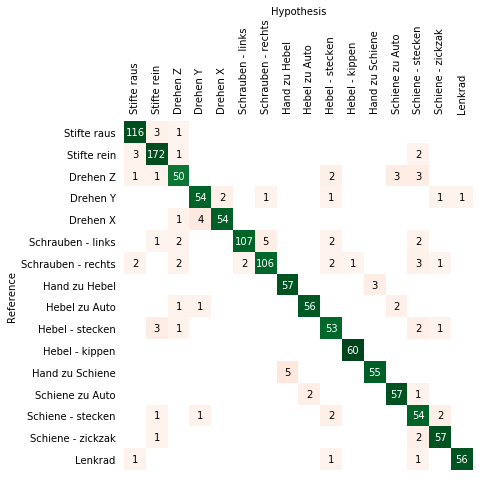

Accuracy = 92.82296650717703
Mode = plots/all10_fusion_101_lda_identity_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 932, 94

<Figure size 432x288 with 0 Axes>

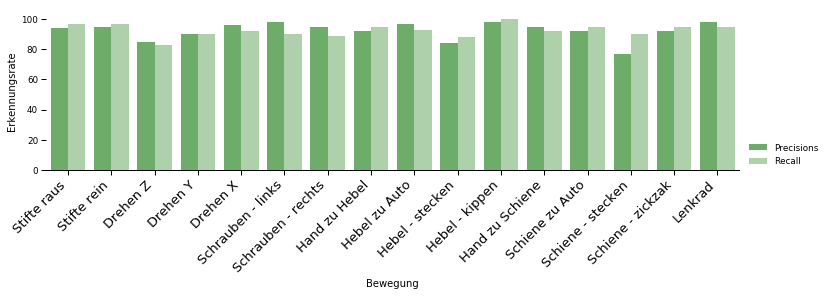

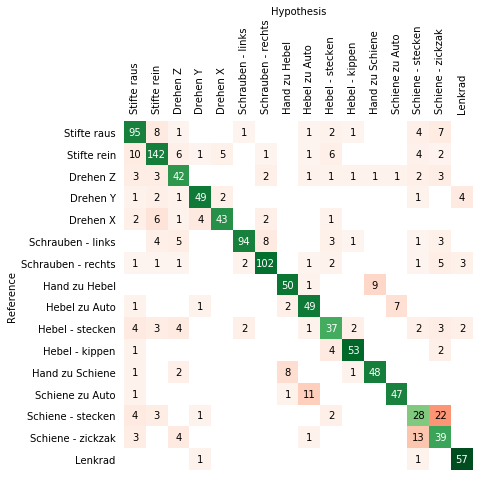

Accuracy = 77.75119617224881
Mode = plots/all10_kinect_121_lda_identity_int1_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 93

<Figure size 432x288 with 0 Axes>

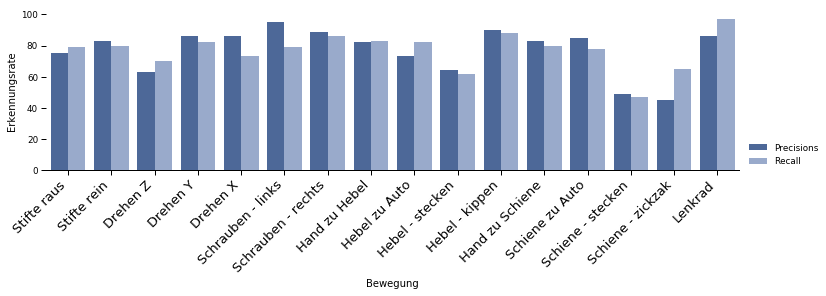

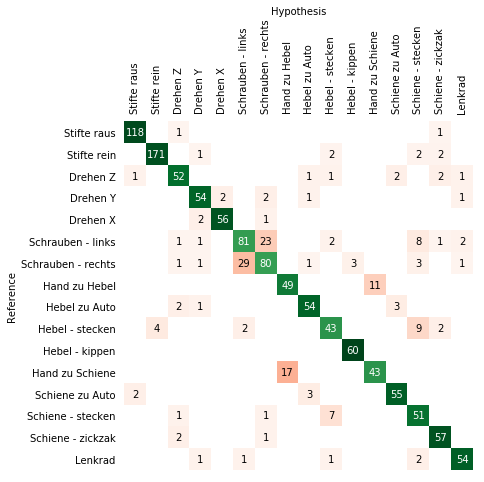

Accuracy = 85.96491228070175
Mode = plots/all10_imu_121_lda_identity_int1_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 932, 

<Figure size 432x288 with 0 Axes>

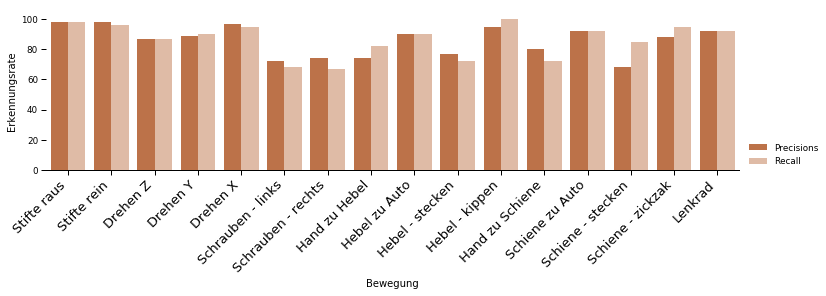

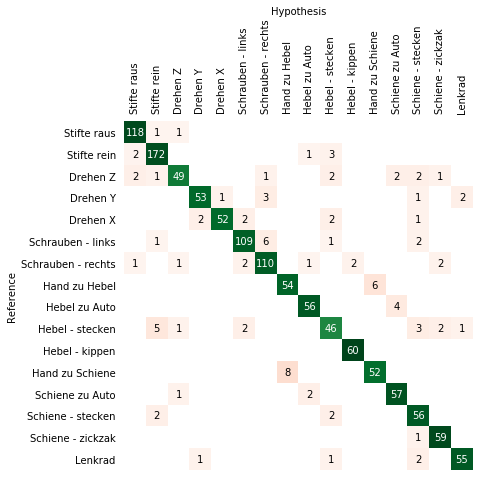

Accuracy = 92.34449760765551
Mode = plots/all10_fusion_121_lda_identity_int1_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 93

<Figure size 432x288 with 0 Axes>

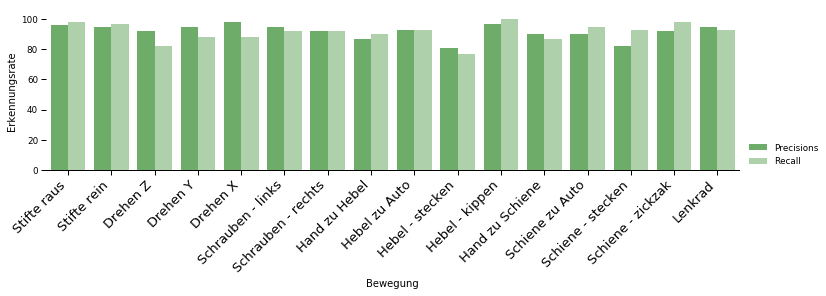

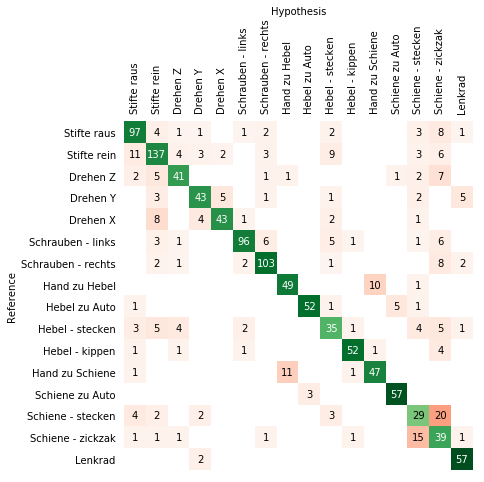

Accuracy = 77.91068580542266
Mode = plots/all10_kinect_131_lda_identity_diff_int1_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 93

<Figure size 432x288 with 0 Axes>

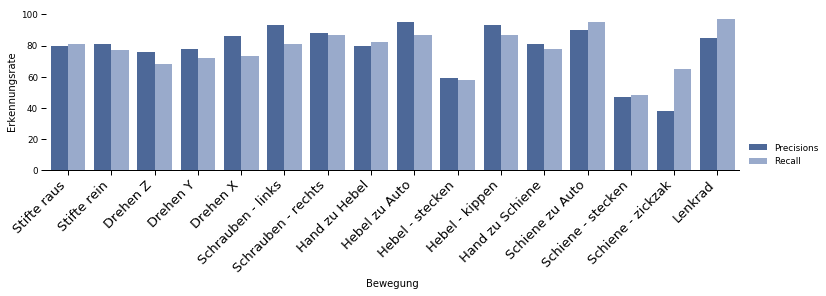

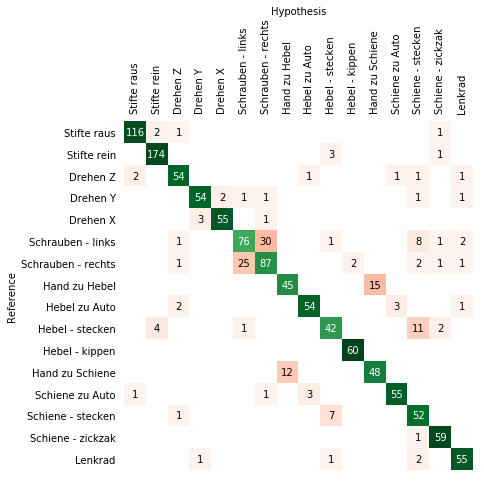

Accuracy = 86.60287081339713
Mode = plots/all10_imu_131_lda_identity_diff_int1_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 931, 

<Figure size 432x288 with 0 Axes>

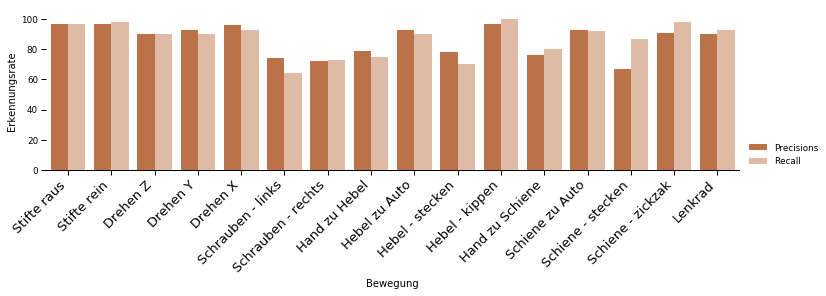

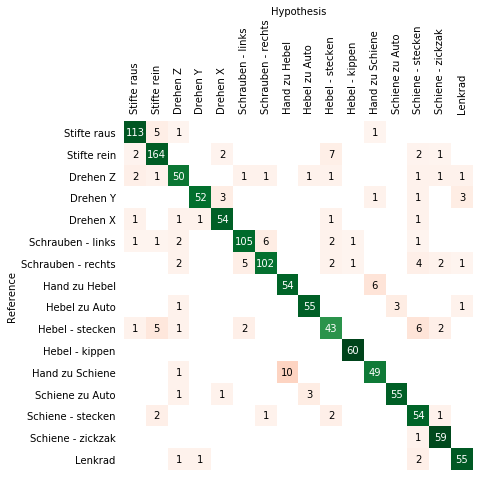

Accuracy = 89.63317384370016
Mode = plots/all10_fusion_131_lda_identity_diff_int1_min_max_mean_noopsnoabc
---train_subjects = None
[2, 3, 7, 8, 23, 24, 28, 29, 44, 45, 49, 50, 65, 66, 70, 71, 86, 87, 91, 92, 107, 108, 112, 113, 128, 129, 133, 134, 149, 150, 154, 155, 170, 171, 175, 176, 191, 192, 196, 197, 212, 213, 217, 218, 233, 234, 238, 239, 254, 255, 259, 260, 275, 276, 280, 281, 296, 297, 301, 302, 317, 318, 322, 323, 338, 339, 343, 344, 359, 360, 364, 365, 380, 381, 385, 386, 401, 402, 406, 407, 422, 423, 427, 428, 443, 444, 448, 449, 464, 465, 469, 470, 485, 486, 490, 491, 506, 507, 511, 512, 527, 528, 532, 533, 548, 549, 553, 554, 569, 570, 574, 575, 590, 591, 595, 596, 611, 612, 616, 617, 632, 633, 637, 638, 653, 654, 658, 659, 674, 675, 679, 680, 695, 696, 700, 701, 716, 717, 721, 722, 737, 738, 742, 743, 758, 759, 763, 764, 779, 780, 784, 785, 800, 801, 805, 806, 821, 822, 826, 827, 842, 843, 847, 848, 863, 864, 868, 869, 884, 885, 889, 890, 905, 906, 910, 911, 926, 927, 93

<Figure size 432x288 with 0 Axes>

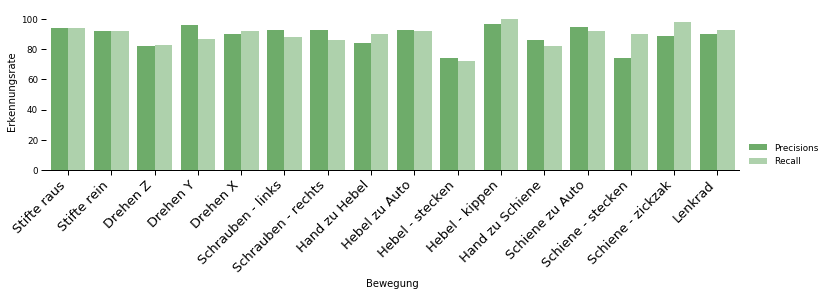

In [30]:
# run pipes with all subjects (LOGO)
# debug = True

# lists for 3 sensors, 6 stat_pipes, 6 diff_pipes, 6 klassifikators
# accs = [[[[[] for _ in range(3)] for _ in range(6)] for _ in range(6)] for _ in range(6)] # wofür? = ud_precs_all_pipes?

save_subjects = False

# Auswahl der Pipe auslagern:
list_klassifikator = [1] # 0 = flat+lda, 1 = lda,4 = rf, 5 = svm
list_diffs = [0,2,3] # 0 = id, 1 = iddiff, 2 = idint1, 3 = iddiffint1, 4 = iddiffint1int2
list_stats = [1] # [1,2,3] = stats 3,4,6, [4,5] = stats 7,9

pred_start_time = datetime.datetime.now()

for klass_index, klassific in enumerate(pipes): # iterate through all klassifikators
    if klass_index not in list_klassifikator: continue # do it only for chosen klassis
    if klass_index in [0]: continue # dont to it for flat + lda
    for pipes_diff_index, pipes_diff in enumerate(klassific): # iterate through all types of pipes (different diff features)
        if pipes_diff_index not in list_diffs: continue # do it only for chosen diffs
        for pipe_stat_index, pipe_stat in enumerate(pipes_diff): # iterate through all pipes of type (different stat features)
            if pipe_stat_index not in list_stats: continue # do it only for chosen stats
            if pipe_stat: # only do it of there is a pipe

                pipe_all = pipe_stat.steps[0][1].transformer_list[0][1] # get pipe_features
                
                pipe_indices = str(klass_index) + str(pipes_diff_index) + str(pipe_stat_index)

                diff_features = pipe_all.steps[0][1].transformer_list
                diff_features_list = [diff_feature[0] for diff_feature in diff_features] # get diff features list

                stat_features = pipe_all.steps[1][1].transformer_list
                stat_features_list = [stat_feature[0] for stat_feature in stat_features] # get stat features list
                
                ###################################################
                #                                                 #
                #                CLASSIFICATION                   #
                #                                                 #
                ###################################################
                
                klassis = ''
                for step_index, step in enumerate(pipe_stat.steps):
                    if step_index == 0: continue
                    if step_index == 2: klassis = klassis + '_'
                    klassis = klassis + str(step[0])
                
                if debug: print(diff_features_list)
                if debug: print(stat_features_list)

                # -----------------------------------------------------------------
                
                # make one array with all segments and targets
                debug = True
                all_data_kin_ar = np.array(all_data_kin)
                all_data_imu_ar = np.array(all_data_imu)
                all_data_fus_ar = np.array(all_data_fus)

                concat_targets_ar = np.array(concat_targets)
                if debug: type(concat_targets)
                
                predicted_kin = []
                predicted_imu = []
                predicted_fus = []
                
                backup_targets = [] # original ones seem to not work... i dont know why
                
                ud_precisions = [] #neu
                
                import sklearn
                from sklearn.metrics import accuracy_score
                
                cv = LeaveOneGroupOut()
                
                # shouldnt make a difference that split is done on all_data_fus but split is used for kin, imu and fus, 
                # because we only use the indices anyway and get data fresh
                for train, test in cv.split(all_data_fus, concat_targets, groups=groups_long): # for all subjects
                    # print(len(test))
                    
                    if np.array(groups_long)[test][0] == np.array(groups_long)[test][-1]: #neu
                        temp_subject = np.array(groups_long)[test][0]
                    
                    # TODO concat_targets_ar erst hier machen?
                    
                    one_predicted_kin = cross_val_predict(pipe_stat, all_data_kin_ar[test], concat_targets_ar[test], cv=LeaveOneOut())
                    one_predicted_imu = cross_val_predict(pipe_stat, all_data_imu_ar[test], concat_targets_ar[test], cv=LeaveOneOut())
                    one_predicted_fus = cross_val_predict(pipe_stat, all_data_fus_ar[test], concat_targets_ar[test], cv=LeaveOneOut())
                    
                    one_accuracy_kin = round(accuracy_score(concat_targets_ar[test], one_predicted_kin) * 100, 2)
                    one_accuracy_imu = round(accuracy_score(concat_targets_ar[test], one_predicted_imu) * 100, 2)
                    one_accuracy_fus = round(accuracy_score(concat_targets_ar[test], one_predicted_fus) * 100, 2)
                    
                    print(one_accuracy_kin, one_accuracy_imu, one_accuracy_fus)
                    ud_precisions.append([one_accuracy_kin, one_accuracy_imu, one_accuracy_fus])
                    
                    predicted_kin.append(one_predicted_kin)
                    predicted_imu.append(one_predicted_imu)
                    predicted_fus.append(one_predicted_fus)
                    
                    backup_targets.append(concat_targets_ar[test])
                    
                    # ---------------   print result   ---------------
                    
                    if save_subjects: # only print subject results if save_subjects is set
                        schriftgroesse = 10
                        import seaborn as sns
                        sns.set_context("paper", rc={"font.size": schriftgroesse, "axes.titlesize": schriftgroesse, "axes.labelsize": schriftgroesse})

                        # ------------------ KIN
                        # predicted_kin.append(one_predicted_kin)

                        name_kin = make_name(subjects=temp_subject, sensors_list=sensors_lists[0],
                                         pipe= pipe_indices, klassifikator=klassis,
                                         diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                         fuse_slots=fuse_slots,
                                         merge_opposites=merge_opposites,
                                         merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                                         with_date=with_date,
                                         show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)

                        make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                                    worked_with, subjects, concat_targets_ar[test], one_predicted_kin, label_dict, name_kin, name_kin)

                        report_kin = sklearn.metrics.classification_report(concat_targets_ar[test], one_predicted_kin)

                        plot_precisions(report_kin, schriftgroesse, name=name_kin, acc=one_accuracy_kin, custom_colors=['#4064a5', '#90a8d4'])
                        save_infos(sensors_list=sensors_lists[0], pipe= pipe_indices, klassifikator=klassis,
                                   diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                   path_list=worked_with, subjects=subjects,
                                   targets=concat_targets_ar[test], predicted=one_predicted_kin,
                                   rename=label_dict, name=name_kin)

                        # ------------------ IMU 
                        # predicted_imu.append(one_predicted_imu)

                        name_imu = make_name(subjects=temp_subject, sensors_list=sensors_lists[1],
                                         pipe= pipe_indices, klassifikator=klassis,
                                         diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                         fuse_slots=fuse_slots,
                                         merge_opposites=merge_opposites,
                                         merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                                         with_date=with_date,
                                         show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)

                        make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                                    worked_with, subjects, concat_targets_ar[test], one_predicted_imu, label_dict, name_imu, name_imu)

                        report_imu = sklearn.metrics.classification_report(concat_targets_ar[test], one_predicted_imu)

                        plot_precisions(report_imu, schriftgroesse, name=name_imu, acc=one_accuracy_imu, custom_colors=['#cf6d36', '#e8b89d'])
                        save_infos(sensors_list=sensors_lists[1], pipe= pipe_indices, klassifikator=klassis,
                                   diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                   path_list=worked_with, subjects=subjects,
                                   targets=concat_targets_ar[test], predicted=one_predicted_imu,
                                   rename=label_dict, name=name_imu)

                        # ------------------ FUS    
                        # predicted_fus.append(one_predicted_fus)

                        name_fus = make_name(subjects=temp_subject, sensors_list=sensors_lists[2],
                                         pipe= pipe_indices, klassifikator=klassis,
                                         diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                         fuse_slots=fuse_slots,
                                         merge_opposites=merge_opposites,
                                         merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                                         with_date=with_date,
                                         show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)

                        make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                                    worked_with, subjects, concat_targets_ar[test], one_predicted_fus, label_dict, name_fus, name_fus)

                        report_fus = sklearn.metrics.classification_report(concat_targets_ar[test], one_predicted_fus)

                        plot_precisions(report_fus, schriftgroesse, name=name_fus, acc=one_accuracy_fus, custom_colors=['#64b75f', '#a8d7a6'])
                        save_infos(sensors_list=sensors_lists[2], pipe= pipe_indices, klassifikator=klassis,
                                   diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                   path_list=worked_with, subjects=subjects,
                                   targets=concat_targets_ar[test], predicted=one_predicted_fus,
                                   rename=label_dict, name=name_fus)
                    
                # ------------------------------------------------------------------    
                
                X_kin = ([j for i in predicted_kin for j in i])
                X_imu = ([j for i in predicted_imu for j in i])
                X_fus = ([j for i in predicted_fus for j in i])
                Y = ([j for i in backup_targets for j in i])

                # if debug: predicted_fus[0][0]
                # if debug: backup_targets[0][0]
                
                print('-'*30)
                
                print(pipe_indices, accuracy_score(Y, X_kin) * 100, accuracy_score(Y, X_imu) * 100, accuracy_score(Y, X_fus) * 100) 
                
                
                ud_precs_all_pipes[klass_index][pipes_diff_index][pipe_stat_index] = ud_precisions
                
                # calc one plot
                ###################################################################double?? why?
                X_kin = ([j for i in predicted_kin for j in i])
                X_imu = ([j for i in predicted_imu for j in i])
                X_fus = ([j for i in predicted_fus for j in i])
                Y = ([j for i in backup_targets for j in i])
                
                acc_kin = accuracy_score(Y, X_kin) * 100
                acc_imu = accuracy_score(Y, X_imu) * 100
                acc_fus = accuracy_score(Y, X_fus) * 100
                
                accs[klass_index][pipes_diff_index][pipe_stat_index][0] = acc_kin
                accs[klass_index][pipes_diff_index][pipe_stat_index][1] = acc_imu
                accs[klass_index][pipes_diff_index][pipe_stat_index][2] = acc_fus
                
                print(pipe_indices, acc_kin, acc_imu, acc_fus)
                
                
                schriftgroesse = 10
                import seaborn as sns
                sns.set_context("paper", rc={"font.size": schriftgroesse, "axes.titlesize": schriftgroesse, "axes.labelsize": schriftgroesse})

                temp_subject = 'all10'
                
                # ------------------ KIN all
                name_kin = make_name(subjects=temp_subject, sensors_list=sensors_lists[0],
                                 pipe= pipe_indices, klassifikator=klassis,
                                 diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                 fuse_slots=fuse_slots,
                                 merge_opposites=merge_opposites,
                                 merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                                 with_date=with_date,
                                 show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)

                make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                            worked_with, subjects, Y, X_kin, label_dict, name_kin, name_kin)

                report_kin = sklearn.metrics.classification_report(Y, X_kin)

                plot_precisions(report_kin, schriftgroesse, name=name_kin, acc=acc_kin, custom_colors=['#4064a5', '#90a8d4'])
                save_infos(sensors_list=sensors_lists[0], pipe= pipe_indices, klassifikator=klassis,
                           diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                           path_list=worked_with, subjects=subjects,
                           targets=Y, predicted=X_kin,
                           rename=label_dict, name=name_kin)

                # ------------------ IMU all
                name_imu = make_name(subjects=temp_subject, sensors_list=sensors_lists[1],
                                 pipe= pipe_indices, klassifikator=klassis,
                                 diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                 fuse_slots=fuse_slots,
                                 merge_opposites=merge_opposites,
                                 merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                                 with_date=with_date,
                                 show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)

                make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                            worked_with, subjects, Y, X_imu, label_dict, name_imu, name_imu)

                report_imu = sklearn.metrics.classification_report(Y, X_imu)

                plot_precisions(report_imu, schriftgroesse, name=name_imu, acc=acc_imu, custom_colors=['#cf6d36', '#e8b89d'])
                save_infos(sensors_list=sensors_lists[1], pipe= pipe_indices, klassifikator=klassis,
                           diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                           path_list=worked_with, subjects=subjects,
                           targets=Y, predicted=X_imu,
                           rename=label_dict, name=name_imu)

                # ------------------ FUS all  
                name_fus = make_name(subjects=temp_subject, sensors_list=sensors_lists[2],
                                 pipe= pipe_indices, klassifikator=klassis,
                                 diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                                 fuse_slots=fuse_slots,
                                 merge_opposites=merge_opposites,
                                 merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                                 with_date=with_date,
                                 show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)

                make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                            worked_with, subjects, Y, X_fus, label_dict, name_fus, name_fus)

                report_fus = sklearn.metrics.classification_report(Y, X_fus)

                plot_precisions(report_fus, schriftgroesse, name=name_fus, acc=acc_fus, custom_colors=['#64b75f', '#a8d7a6'])
                save_infos(sensors_list=sensors_lists[2], pipe= pipe_indices, klassifikator=klassis,
                           diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                           path_list=worked_with, subjects=subjects,
                           targets=Y, predicted=X_fus,
                           rename=label_dict, name=name_fus)
                
                
                
                

pred_end_time = datetime.datetime.now()

print('prediction duration = {}'.format(pred_end_time - pred_start_time))

In [31]:
print('preparation duration = {}'.format(pred_end_time - pred_start_time))

preparation duration = 0:03:46.836344


In [27]:
backup_accs_all_pipes = accs ###########################################################  BACKUP

In [28]:
# accs = [klassifikator] [diffs] [stats] [sensor]

In [29]:
accs_ar = np.array(accs)

In [30]:
test = [[[[[] for _ in range(3)] for _ in range(6)] for _ in range(6)] for _ in range(6)]

In [31]:
# accs # = [Klassi][Diff][Stat][Sensor][0] = Acc, jede Acc ist in einer einzelnen Einerliste...

In [32]:
# [][][] von Einzelnlisten in Dreierlisten rausholen
accs2 = [ [ [ [ sensor if sensor else 0 for sensor in stats] for stats in diffs] for diffs in klassis] for klassis in accs]

In [33]:
accs2[1][3][1] # Acc für Klassi 1, Diff 3, Stat 3, alle drei Sensoren

[68.6602870813397, 86.60287081339713, 88.51674641148325]

In [34]:
accs2_ar = np.array(accs2)

In [35]:
# accs = [klassifikator] [diffs] [stats] [sensor]

In [36]:
# accs = [klassifikator] [diffs] [stats] [sensor]

In [37]:
table = [[[] for _ in range(6)] for _ in range(6)]  # list with 6 lists of 6 empty lists

In [38]:
table

[[[], [], [], [], [], []],
 [[], [], [], [], [], []],
 [[], [], [], [], [], []],
 [[], [], [], [], [], []],
 [[], [], [], [], [], []],
 [[], [], [], [], [], []]]

In [39]:
for k_index, klassis in enumerate(accs2):
    for diff_index, diffs in enumerate(klassis):
        df = pd.DataFrame({'Klassi':[k_index, k_index, k_index],'Diff':[diff_index, diff_index, diff_index],
                           'Sensor':['Kinect', 'IMU', 'Fusion'],
                           'stat0':accs2_ar[k_index][diff_index].T[:,0],'stat1':accs2_ar[k_index][diff_index].T[:,1],
                           'stat2':accs2_ar[k_index][diff_index].T[:,2],'stat3':accs2_ar[k_index][diff_index].T[:,3],
                           'stat4':accs2_ar[k_index][diff_index].T[:,4],'stat5':accs2_ar[k_index][diff_index].T[:,5]})
        table[k_index][diff_index] = df

In [40]:
klassis_table = [[] for _ in range(len(accs2))]

In [41]:
for k_index, klassis in enumerate(accs2):
    single_table = pd.concat([table[k_index][0], table[k_index][1], table[k_index][2], table[k_index][3], table[k_index][4]], ignore_index=True)

    # single_table
    # single_table.sort_values(by=['Sensor'], ascending=False)

    # to rename diffs indices in table making process
    diffs_dict = {
        0: 'id',
        1: 'id, diff',
        2: 'id, int1',
        3: 'id, diff, int1',
        4: 'id, diff, int1, int2'
    }

    # to rename classificator indices in table making process
    classificator_dict = {
        0: 'flat + lda',
        1: 'lda',
        2: 'pca + lda',
        3: 'pca + rf',
        4: 'ss + rf',
        5: 'ss + svm'
    }
    
    # from rename_labels import classificator_dict
    single_table['Klassi'] = [classificator_dict[i] for i in single_table['Klassi']]

    # from rename_labels import diffs_dict
    single_table['Diff'] = [diffs_dict[i] for i in single_table['Diff']]

    # single_table

    single_table = single_table[single_table['Diff'].isin(['id', 'id, diff', 'id, int1', 'id, diff, int1', 'id, diff, int1, int2'])]

    # single_table

    # single_table.iloc[:,1:]
    
    single_table = single_table.iloc[:,1:]

    # np.savetxt("new_accs_klass_" + str(k_index) + ".csv", single_table, delimiter=' & ', fmt=' '.join(['%s'] + [' & %s'] + ([' & %1.2f'])*6), newline=' \\\\\n')
    
    single_table['Kl'] = k_index
    
    klassis_table[k_index] = single_table

In [42]:
len(klassis_table)

6

In [43]:
klassis_table[1]

,Diff,Sensor,stat0,stat1,stat2,stat3,stat4,stat5,Kl
0,id,Kinect,0.0,55.821372,55.023923,56.140351,57.416268,57.735247,1
1,id,IMU,0.0,83.253589,83.253589,84.210526,84.688995,85.087719,1
2,id,Fusion,0.0,92.503987,92.025518,91.626794,90.909091,89.074960,1
3,"id, diff",Kinect,0.0,63.556619,61.881978,63.636364,62.998405,59.090909,1
4,"id, diff",IMU,0.0,83.413078,81.977671,85.486443,84.210526,83.811802,1
5,"id, diff",Fusion,0.0,91.467305,88.676236,86.682616,82.376396,69.936204,1
6,"id, int1",Kinect,0.0,69.138756,67.703349,68.102073,67.543860,60.207337,1
7,"id, int1",IMU,0.0,86.523126,85.885167,85.566188,85.885167,84.051037,1
8,"id, int1",Fusion,0.0,91.626794,89.792663,87.958533,83.333333,83.094099,1
9,"id, diff, int1",Kinect,0.0,68.660287,65.789474,65.948963,62.759171,34.290271,1


In [44]:
all_kl_table = pd.concat([klassis_table[0], klassis_table[1], klassis_table[2], klassis_table[3], klassis_table[4], klassis_table[5]], ignore_index=True)

In [45]:
# rearrange columns

In [46]:
cols = all_kl_table.columns.tolist()

In [47]:
cols = cols[-1:] + cols[:-1]

In [48]:
all_kl_table = all_kl_table[cols]

In [49]:
all_kl_table['Kl'] = [classificator_dict[i] for i in all_kl_table['Kl']]

In [50]:
all_kl_table = all_kl_table[all_kl_table['Kl'].isin(['lda', 'pca + lda', 'pca + rf', 'ss + rf', 'ss + svm'])]

In [51]:
all_kl_table = all_kl_table[['Kl', 'Diff', 'Sensor', 'stat1', 'stat2', 'stat3', 'stat4', 'stat5']]

In [52]:
np.savetxt("plots/accs_all_pipes.csv", all_kl_table, delimiter=' & ', fmt=' '.join(['%s'] + [' & %s']*2 + ([' & %1.2f'])*5), newline=' \\\\\n')

In [53]:
all_kl_table_fus = all_kl_table[all_kl_table['Sensor'].isin(['Fusion'])]

In [54]:
np.savetxt("plots/accs_all_pipes_fus.csv", all_kl_table_fus, delimiter=' & ', fmt=' '.join(['%s'] + [' & %s']*2 + ([' & %1.2f'])*5), newline=' \\\\\n')

In [55]:
all_kl_table_fus_min = all_kl_table_fus[all_kl_table_fus['Kl'].isin(['lda', 'ss + rf', 'ss + svm'])]

In [56]:
colstemp = all_kl_table_fus_min.columns.tolist()

In [57]:
colstemp

['Kl', 'Diff', 'Sensor', 'stat1', 'stat2', 'stat3', 'stat4', 'stat5']

In [58]:
all_kl_table_fus_min = all_kl_table_fus_min[['Kl', 'Diff', 'stat1', 'stat2', 'stat3', 'stat4', 'stat5']]

In [59]:
np.savetxt("plots/accs_klassi145_fus_min.csv", all_kl_table_fus_min, delimiter=' & ', fmt=' '.join(['%s'] + [' & %s'] + ([' & %1.2f'])*5), newline=' \\\\\n')

In [62]:
kl_nr = 1
single_table = pd.concat([table[kl_nr][0], table[kl_nr][1], table[kl_nr][2], table[kl_nr][3], table[kl_nr][4]], ignore_index=True)

# single_table
# single_table.sort_values(by=['Sensor'], ascending=False)

# to rename diffs indices in table making process
diffs_dict = {
    0: 'id',
    1: 'id, diff',
    2: 'id, int1',
    3: 'id, diff, int1',
    4: 'id, diff, int1, int2'
}

# to rename classificator indices in table making process
classificator_dict = {
    0: 'flat + lda',
    1: 'lda',
    2: 'pca + lda',
    3: 'pca + rf',
    4: 'ss + rf',
    5: 'ss + svm'
}

# from rename_labels import classificator_dict
single_table['Klassi'] = [classificator_dict[i] for i in single_table['Klassi']]

# from rename_labels import diffs_dict
single_table['Diff'] = [diffs_dict[i] for i in single_table['Diff']]

# single_table

single_table = single_table[single_table['Diff'].isin(['id', 'id, diff', 'id, int1', 'id, diff, int1', 'id, diff, int1, int2'])]

# single_table

single_table = single_table[['Diff', 'Sensor', 'stat1', 'stat2', 'stat3', 'stat4', 'stat5']]

np.savetxt("plots/accs_klass_" + str(kl_nr) + ".csv", single_table, delimiter=' & ', fmt=' '.join(['%s'] + [' & %s'] + ([' & %1.2f'])*5), newline=' \\\\\n')